In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/3440568461.csv', header=None, names=['time','lat','lon','elev','power'])

In [6]:
from collections import deque

def power_curve_breakpoints(df):
    SECONDS_MAX = 300
    FIVE_SECONDS_MAX = 600
    TEN_SECONDS_MAX = 1200
    THIRTY_SECONDS_MAX = df.shape[0]

    power_curve = np.hstack([np.arange(1,SECONDS_MAX*5+1),
                         np.arange(SECONDS_MAX+5,FIVE_SECONDS_MAX+5,5),
                         np.arange(FIVE_SECONDS_MAX+10,TEN_SECONDS_MAX+10,10),
                         np.arange(TEN_SECONDS_MAX+30,THIRTY_SECONDS_MAX+30,30)])
    
    return power_curve

class CurveCalculator:
    def __init__(self, curve_len):
        self.curve_len = curve_len
        self.last_seen = deque(maxlen=self.curve_len)
        self.max_avg_power = 0
        
    def push(self, power):
        if len(self.last_seen) == self.curve_len:
            self.last_seen.append(power)
            maxavgp = sum(self.last_seen)/self.curve_len
            if maxavgp > self.max_avg_power:
                self.max_avg_power = maxavgp
        else:
            self.last_seen.append(power)
        
    def get_current_power(self):
        return self.max_avg_power
    
power_curve = power_curve_breakpoints(df)
cc = CurveCalculator(2)

In [7]:
all_windows = {i:CurveCalculator(int(i)) for i in power_curve}

for i in df['power']:
    for cl, aw in all_windows.items():
        aw.push(i)

In [8]:
all_cl = {i:all_windows[i].get_current_power() for i in all_windows.keys()}

In [9]:
all_cl[3810]

242.41627296587927

In [10]:
def calculate_power_curve(df):
    power_curve = power_curve_breakpoints(df)
    power_curve_df = pd.DataFrame(power_curve.T, columns=['window'])
    power_curve_df['power'] = 0
    power_curve_df['start'] = 0
    power_curve_df['end'] = 0
    for i, row in power_curve_df.iterrows():
        power_curve_df.loc[i,'power'] = df['power'].rolling(window=row.window).mean().max()
        power_curve_df.loc[i,'end'] = df['power'].rolling(window=row.window).mean().argmax()

        start = power_curve_df.loc[i,'end'] - row.window
        if start < 0:
            start = 0
        power_curve_df.loc[i,'start'] = start

    power_curve_df = power_curve_df.dropna(axis=0)
    return power_curve_df

power_curve_df = calculate_power_curve(df)

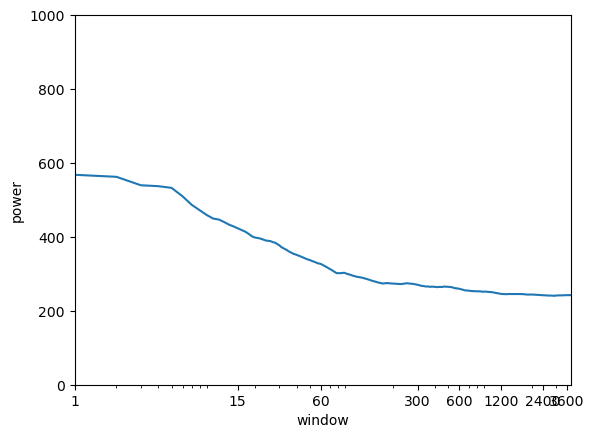

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator

lp = sns.lineplot(x='window',y='power',data=power_curve_df)
lp.set(xscale='log')
lp.set(xticks=[1,15,60,300,600,1200, 2400, 3600])
lp.set(xticklabels=[1,15,60,300,600,1200, 2400, 3600])
plt.xlim(1,df.shape[0])
plt.ylim(0,1000)
plt.show()

In [13]:
data2 = df

In [14]:
calculate_power_curve(data2)

,window,power,start,end
0,1,568.000000,1561,1562
1,2,562.500000,1560,1562
2,3,539.666667,1560,1563
3,4,537.250000,1560,1564
4,5,532.600000,1560,1565
...,...,...,...,...
1702,3690,242.509485,115,3805
1703,3720,242.547849,84,3804
1704,3750,242.396800,55,3805
1705,3780,242.539947,24,3804


In [68]:
import folium

def plot_map(df, power_curve_df, best_power_window):
    start_power_loc, end_power_loc = power_curve_df.loc[power_curve_df['window']==best_power_window,['start','end']].values[0]
    start_lat, start_lon = df.loc[0,['lat','lon']].values
    m = folium.Map([start_lat, start_lon], zoom_start=15)

    line_pre = df.iloc[:start_power_loc].loc[:,['lat','lon']]
    line_post = df.iloc[end_power_loc:].loc[:,['lat','lon']]
    line_power = df.iloc[start_power_loc:end_power_loc].loc[:,['lat','lon']]
    folium.PolyLine(line_pre,color='blue').add_to(m)
    folium.PolyLine(line_power,color='red').add_to(m)
    folium.PolyLine(line_post,color='blue').add_to(m)
    return m

fm = plot_map(df, power_curve_df, 480)
fm